# How to a Run Semantic Skill from File
Here we'll explore how the kernel allows you to run Semantic Skills and Semantic Functions stored on disk. 

This Demonstration is adapted from the notebook [02-running-prompts-from-file.ipynb](02-running-prompt-from-file.ipynb):

A Semantic Skill is a collection of Semantic Functions, where each function is defined using natural language that can be provided with a text file. 

Refer to our [glossary](https://github.com/microsoft/semantic-kernel/blob/main/docs/GLOSSARY.md) for an in-depth guide to the terms.

The repository includes some examples under the [samples](https://github.com/microsoft/semantic-kernel/tree/main/samples) folder.

A plugin is a collection of semantic functions (i.e., prompts) that can be loaded into the kernel. Every plugin follows a similar structure, which is described in the ai plugin section of the documentation. At a high level though, a plugin is a folder that contains additional folders, one for each semantic function.

```
MySemanticPlugin (a directory)
│
└─── MyFirstSemanticFunction (a directory)
|   |
│   └───config.json
│   └───skprompt.txt
|
└─── MyOtherSemanticFunction (a directory)
    |
    └───config.json
    └───skprompt.txt
```

For example, [this](../../skills/WriterSkill/EmailSenderDemo/skprompt.txt) is the **EmailSenderDemo function** that I've prepared expressly for this demonstration by adding it to the **WriterSkill skill**: 

```
WriterSkill (a directory)
│
└─── EmailSenderDemo (a directory)
    |
    └───config.json
    └───skprompt.txt

```

Inside each semantic function folder there is a **`skprompt.txt`** file that contains a **`prompt template`**, and a **`config.json`** file that describes the configuration of the semantic function.  The following text illustrates how the contents of the **`prompt template`** include textual prompt information along with the **`variables`** required to integrate user-defined information.

```
Write an email based on the given text
Use a {{$tone}} tone.
The email should be {{$length}}.
The email should be from {{$sender}}.

{{$input}}
```

Note the special **`{{$input}}`** token, which is a variable that is automatically passed when invoking the function, commonly referred to as a "function parameter".  In this example we'll pass in a **description** of the email we'd like the **function** to generate for us.

Also note how functions can accept multiple variables, as well as invoke other functions. Here I've added user-defined variables for the **`{{$tone}}`**, **`{{$length}}`**, and **`{{$sender}}`** of the custom email being written.


In the same folder you'll notice a second [config.json](../../skills/FunSkill/Joke/config.json) file. The file is optional, and is used to set some parameters for large language models like Temperature, TopP, Stop Sequences, etc.

```
{
  "schema": 1,
  "type": "completion",
  "description": "Write an email based on the given information",
  "completion": {
    "max_tokens": 1000,
    "temperature": 0.0,
    "top_p": 0.0,
    "presence_penalty": 0.0,
    "frequency_penalty": 0.0
  },
  "input": {
    "parameters" : [
        {
            "name": "input",
            "description": "What the email should be about.",
            "defaultValue": ""
        },
        {
            "name": "tone",
            "description": "The tone of the email.",
            "defaultValue": "Professional"
        },
        {
            "name": "length",
            "description": "The length of the email.",
            "defaultValue": ""
        },
        {
            "name": "sender",
            "description": "The person who will send the email.",
            "defaultValue": ""
        }
    ]
  }
}
```

Given a semantic function defined by these files, this is how to load and use a file based semantic function.

Load and configure the kernel, as usual, loading also the AI service settings defined in the [Setup notebook](00-getting-started.ipynb):

### 1. Start Using the Semantic Kernal SDK
- Instantiate the Semantic Kernal
- Get a reference to the Azure OpenAI Service and the ChatCompletion connector

In [1]:
import semantic_kernel as sk
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion, OpenAIChatCompletion

kernel = sk.Kernel()

useAzureOpenAI = True

# Configure AI service used by the kernel
if useAzureOpenAI:
    deployment, api_key, endpoint = sk.azure_openai_settings_from_dot_env()
    kernel.add_chat_service("chat_completion", AzureChatCompletion(deployment, endpoint, api_key))
else:
    api_key, org_id = sk.openai_settings_from_dot_env()
    kernel.add_chat_service("chat-gpt", OpenAIChatCompletion("gpt-3.5-turbo", api_key, org_id))

### 2. Import my custom skill and all its functions:

In [2]:
# note: using skills from the samples folder
skills_directory = "../../samples/skills"

writerFunctions = kernel.import_semantic_skill_from_directory(skills_directory, "WriterSkill")

emailFunction = writerFunctions["EmailSenderDemo"]

### 3. Define and intitialize the variables we'll be using 

In [4]:
emailTone = "Professional"
emailLength = "Short"
emailUserInput = "I need to respond to Kevin about the presentation I'll be giving to The Home Depot developer community."
emailSender = "Jon Tupitza"

### 4. Now Call the EmailSenderDemo Functions

In [5]:
context = kernel.create_new_context()

context["tone"] = emailTone
context["length"] = emailLength
context["input"] = emailUserInput
context["sender"] = emailSender

asychronousCall = True

if asychronousCall:
    result = await emailFunction.invoke_async(context=context)
else:
    result = emailFunction(context=context)

print(result)

Subject: Response to Presentation for The Home Depot Developer Community

Dear Kevin,

I hope this email finds you well. I am writing to respond to your inquiry about the presentation I will be giving to The Home Depot developer community.

I am pleased to confirm that I will be presenting on the topic of "Innovative Solutions for E-commerce Platforms" on the scheduled date. I am excited to share my insights and expertise with the audience and look forward to a productive session.

Please let me know if there are any specific requirements or expectations that I should keep in mind while preparing for the presentation. I am happy to accommodate any requests or suggestions that you may have.

Thank you for your time and consideration. I look forward to working with you and The Home Depot team.

Best regards,

Jon Tupitza


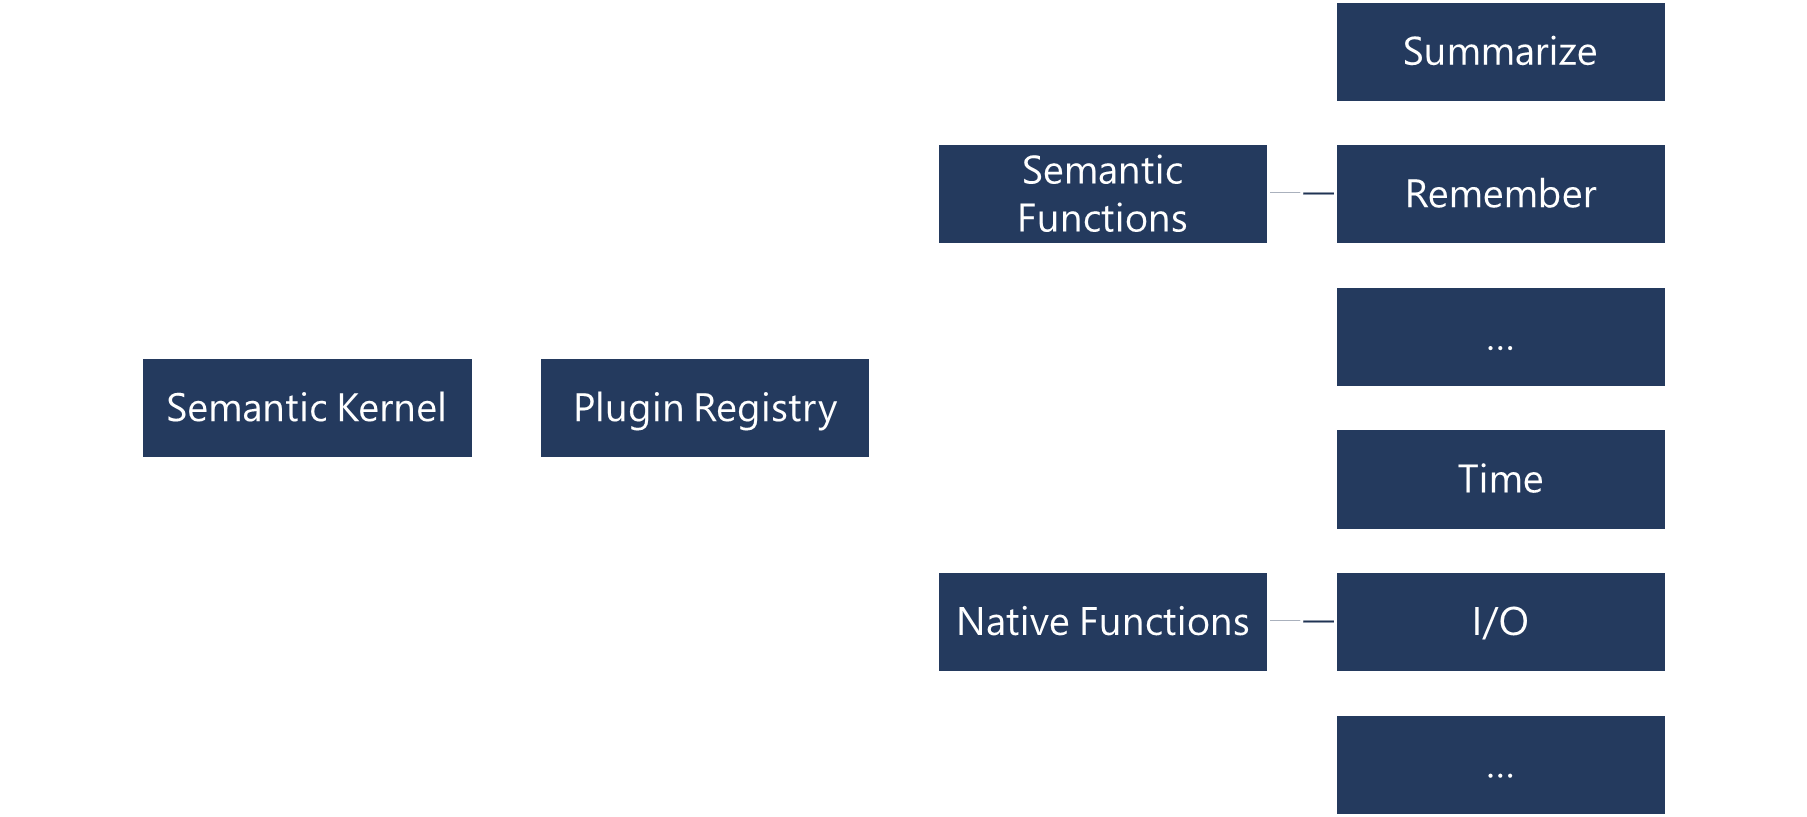